### Movie Review Sentiment Analysis Using TensorFlow 
We use term frequency-inverse document frequency (TF-IDF) to weigh words and build a vocabulary for use as a vector. TensorFlow is used to develop a one-layer NN for quick training.

#### Import statements

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.framework import ops
from time import time
ops.reset_default_graph()

In [2]:
batch_size = 500  # 200
max_features = 2000  # 1000

In [ ]:
file = open('/Users/<>/Documents/Data/smsspamcollection/SMSSpamCollection', 
            encoding="utf-8")
# Format Data
text_data = file.read().split('\n')
text_data = [x.split('\t') for x in text_data if len(x)>=1]

"""
import csv
save_file_name = '/Users/<>/Documents/Data/smsspamcollection/temp_spam_data.csv'
# And write to csv
with open(save_file_name, 'w', encoding="utf-8") as temp_output_file:
    writer = csv.writer(temp_output_file)
    writer.writerows(text_data)
"""

#### Data read

In [4]:
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

# Relabel 'spam' as 1, 'ham' as 0
target = [1. if x=='spam' else 0. for x in target]

# Normalize text
# Lower case
texts = [x.lower() for x in texts]

# Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

In [5]:
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

# Create TF-IDF of texts
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', max_features=max_features)
sparse_tfidf_texts = tfidf.fit_transform(texts)

In [6]:
train_indices = np.random.choice(sparse_tfidf_texts.shape[0], 
                                 round(0.8*sparse_tfidf_texts.shape[0]), replace=False)
test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) - set(train_indices)))
texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

In [7]:
# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[max_features,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[None, max_features], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Declare logistic model (sigmoid in loss function)
model_output = tf.add(tf.matmul(x_data, A), b)

In [8]:
# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, 
                                                              labels=y_target))

# Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [9]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.0025)
train_step = my_opt.minimize(loss)

# Intitialize Variables
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [10]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
t1 = time()
for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], size=batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100==0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={x_data: texts_test.todense(), 
                                                   y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict={x_data: texts_test.todense(), 
                                                      y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
        
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Iteration # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

print("Iterations took %.3f secs" % (time() - t1))

Iteration # 500. Train Loss (Test Loss): 0.82 (0.84). Train Acc (Test Acc): 0.47 (0.47)
Iteration # 1000. Train Loss (Test Loss): 0.66 (0.70). Train Acc (Test Acc): 0.61 (0.60)
Iteration # 1500. Train Loss (Test Loss): 0.56 (0.61). Train Acc (Test Acc): 0.71 (0.68)
Iteration # 2000. Train Loss (Test Loss): 0.57 (0.56). Train Acc (Test Acc): 0.73 (0.74)
Iteration # 2500. Train Loss (Test Loss): 0.52 (0.52). Train Acc (Test Acc): 0.77 (0.78)
Iteration # 3000. Train Loss (Test Loss): 0.51 (0.50). Train Acc (Test Acc): 0.79 (0.80)
Iteration # 3500. Train Loss (Test Loss): 0.50 (0.48). Train Acc (Test Acc): 0.79 (0.81)
Iteration # 4000. Train Loss (Test Loss): 0.55 (0.47). Train Acc (Test Acc): 0.80 (0.83)
Iteration # 4500. Train Loss (Test Loss): 0.45 (0.47). Train Acc (Test Acc): 0.85 (0.83)
Iteration # 5000. Train Loss (Test Loss): 0.45 (0.46). Train Acc (Test Acc): 0.84 (0.84)
Iteration # 5500. Train Loss (Test Loss): 0.50 (0.46). Train Acc (Test Acc): 0.81 (0.84)
Iteration # 6000. Trai

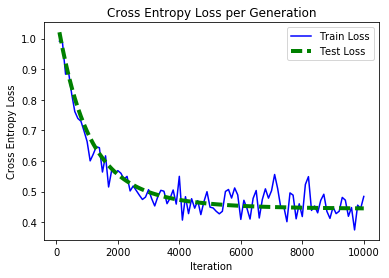

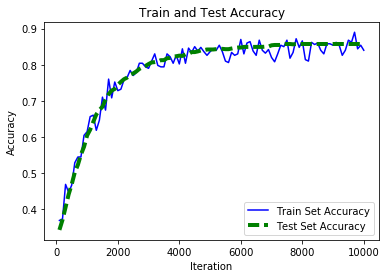

In [11]:
# Plot loss over time
plt.plot(i_data, train_loss, 'b-', label='Train Loss')
plt.plot(i_data, test_loss, 'g--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'b-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'g--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()